In [24]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import pyro
import torch

softmax = torch.nn.Softmax(-1)                     # softmax transform along the last dimension
pad = torch.nn.ConstantPad1d((1,0), 0.)            # Add a 0 to a tensor

import sys
sys.path.insert(0, "/home/djl34/lab_pd/simulator/code")
from others import round_sig

In [31]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax



In [2]:
df_neutral = pd.read_csv("/home/djl34/lab_pd/kl/data/whole_genome/neutral/5_bins/all.tsv", sep = "\t")

In [3]:
df = pd.read_csv("/home/djl34/scratch/kl_input/window_1k/1_split_500_0.tsv", sep = "\t")

In [4]:
df.groupby("window_1k").size()[df.groupby("window_1k").size() > 2500]

window_1k
91     3452
96     3085
108    2685
119    2686
121    2732
       ... 
568    2991
569    3462
570    2955
573    2988
574    3206
Length: 276, dtype: int64

## pick a window

In [174]:
df_window = df[df["window_1k"] == 230]

print(len(df_window))

gene = df_window["gene"].iloc[0]

2512


In [175]:
df_window.groupby("mu_index").size()[df_window.groupby("mu_index").size() > 20]

mu_index
0     173
1     453
2     387
3     280
4     203
5     163
6     104
7      84
8     110
9     104
10     69
11     61
12     51
13     45
14     33
15     28
17     36
dtype: int64

## pick a mu bin

In [176]:
mu_bin = 17

df_window_mu = df_window[df_window["mu_index"] == mu_bin]

df_window_mu_sfs = pd.DataFrame((df_window_mu.groupby("Freq_bin").size())/len(df_window_mu)).reset_index()

for i in range(5):
    if len(df_window_mu_sfs[df_window_mu_sfs["Freq_bin"] == i]) == 0:
        df_window_mu_sfs.loc[i] = [i, 0.0]
    
df_window_mu_sfs.rename({0: "observed"}, axis = 1, inplace = True)

df_window_mu_sfs["neutral"] = pd.Series(df_neutral.iloc[mu_bin, 1:6]).reset_index(drop = True)

## look at raklette outputs

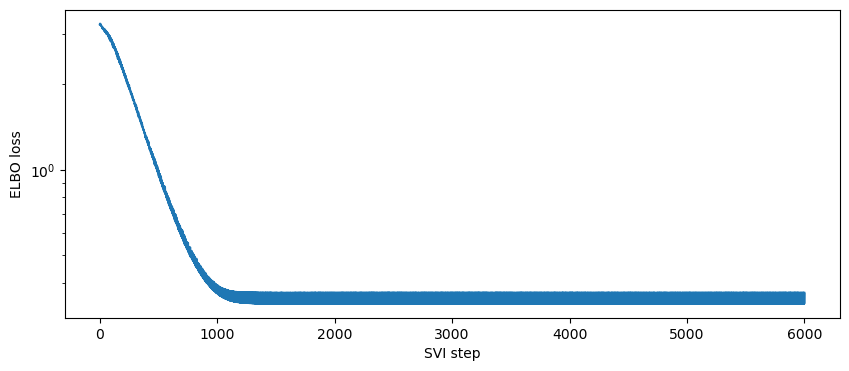

In [185]:
file_dir = "/home/djl34/lab_pd/kl/data/raklette_output/gene_and_covariates/window_1k/"
# filename = "1_split_500_0_lr_0.01_gamma_0.1_epoch_1000_nopriorfit.pkl"
filename = "1_split_500_0_lr_0.01_gamma_0.1_epoch_3000.pkl"

# model_filename = file_dir + "1_split_500_0_lr_0.01_gamma_0.1_epoch_1000_nopriorfit.save"
# model_filename = file_dir + "1_split_500_0_lr_0.01_gamma_0.1_epoch_1000.save"

with open(file_dir + filename, 'rb') as f:
    loaded_dict = pickle.load(f)

In [197]:
#calculate posterior SFS
fit = loaded_dict

beta_neut_full = fit["beta_neut_full"]
mu_ref = fit["mu_ref"]
ref_mu_ii = mu_bin
# ref_mu_ii = 
beta_neut = beta_neut_full[ref_mu_ii,:] # neutral betas for the reference mutation rate

beta_prior_b = fit["beta_prior_b"] # need the interaction term between mutation rate and selection
post_samples = fit["post_samples"] # grab dictionary with posterior samples

post_trans = torch.cumsum(torch.abs(post_samples["beta_sel"]), dim=-1)
# post_trans = torch.cumsum(post_samples["beta_sel"], dim=-1)

In [198]:
post_probs = softmax(pad(beta_neut - post_trans -
                      mu_ref[ref_mu_ii]*torch.cumsum(beta_prior_b, -1)*post_trans)).detach().numpy()

list((post_probs.mean(axis = 0)[gene]))

[0.9989938420669278,
 0.0009811807565975614,
 1.5593931835048615e-05,
 7.46429694139476e-06,
 1.9189477002121133e-06]

In [ ]:
mu_adj = self.mu_ref[...,None] * torch.cumsum(beta_prior_b, -1) * beta_trans[...,None,:]
mn_sfs = (self.beta_neut  -
          beta_trans[...,None,:] -
          mu_adj)

In [199]:
df_window_mu_sfs["posterior"] = list((post_probs.mean(axis = 0)[gene]))

df_window_mu_sfs_melt = pd.melt(df_window_mu_sfs, id_vars=['Freq_bin'], value_vars=['observed', 'neutral', 'posterior'])

print(df_neutral.iloc[mu_bin]["mu"])
print(len(df_window_mu))

print(round_sig(float(loaded_dict["KL_fw_post"].mean(axis = 0)[gene]), 3))
print(round_sig(float(loaded_dict["KL_rv_post"].mean(axis = 0)[gene]), 3))

df_window_mu_sfs["observed"] = [round_sig(x, 3) for x in df_window_mu_sfs["observed"]]
df_window_mu_sfs["neutral"] = [round_sig(x, 3) for x in df_window_mu_sfs["neutral"]]
df_window_mu_sfs["posterior"] = [round_sig(x, 3) for x in df_window_mu_sfs["posterior"]]

0.198
36
2.8
3.05


(<Figure size 800x600 with 1 Axes>, <AxesSubplot:>)

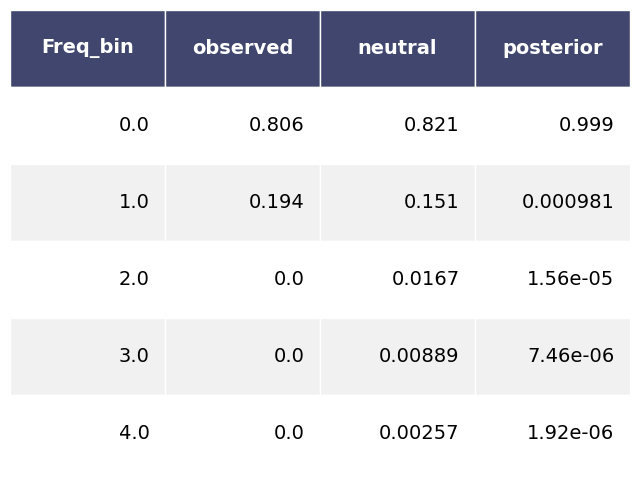

In [200]:
render_mpl_table(df_window_mu_sfs, col_width = 2)

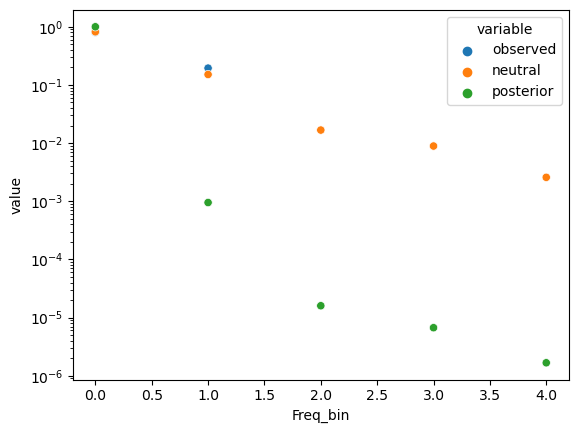

In [182]:
g = sns.scatterplot(data=df_window_mu_sfs_melt, x="Freq_bin", y="value", hue = "variable")
g.set_yscale("log")